## 0. Preparing Input for Training Model

In [ ]:
import os
os.chdir("")

from src.utils.utils import update_label_map
from config.paths import label_map_path, augmented_data_dir
import json
import glob
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# update_label_map(augmented_data_dir, label_map_path)

In [15]:
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
DATA_PATH = "dataset/new_data_v3"

with open(label_map_path, 'r', encoding='utf-8') as f:
    label_map = json.load(f)
    
labels = label_map.keys()

all_files = []
for label in labels:
    label_dir = os.path.join(DATA_PATH, label)
    for path in glob.glob(os.path.join(label_dir, '*.npy')):
        all_files.append((path, label_map[label]))

print(f"Found {len(all_files)} samples across {len(label_map)} classes.")

paths, labels = zip(*all_files)
train_files, temp_files, y_train, y_temp = train_test_split(
    paths, labels,
    test_size=VAL_SPLIT + TEST_SPLIT,
    shuffle=True, stratify=labels, random_state=42
)
val_files, test_files, y_val, y_test = train_test_split(
    temp_files, y_temp,
    test_size=TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT),
    shuffle=True, stratify=y_temp, random_state=42
)

print(f"Train samples: {len(train_files)}")
print(f"Val samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")

Found 10000 samples across 100 classes.
Train samples: 6999
Val samples: 2000
Test samples: 1001


In [16]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def _load_npy(path, label):
    data = np.load(path.decode('utf-8'), allow_pickle=True)
    frames = []
    for frame in data:
        # frame = [left_hand, right_hand, pose]
        concat = np.concatenate(frame)  # (n_keypoints_total, 3)
        frames.append(concat.flatten())  # vector 1D
    seq = np.stack(frames)  # (20, 177)
    return seq.astype(np.float32), np.int32(label)

def parse_fn(path, label):
    seq, lbl = tf.numpy_function(_load_npy, [path, label], [tf.float32, tf.int32])
    seq.set_shape([30, 177])  # ví dụ shape cố định (frames, features)
    lbl.set_shape([])
    return seq, lbl

def make_dataset(paths, labels, shuffle=False, repeat=False):
    ds = tf.data.Dataset.from_tensor_slices((list(paths), list(labels)))
    if shuffle:
        ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)
    if repeat:
        ds = ds.repeat()
    ds = ds.map(parse_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_files, y_train, shuffle=True, repeat=True)
val_ds   = make_dataset(val_files, y_val)
test_ds  = make_dataset(test_files, y_test)

steps_per_epoch = len(train_files) // BATCH_SIZE
validation_steps = len(val_files) // BATCH_SIZE

In [17]:
print(tf.data.experimental.get_structure(train_ds))

(TensorSpec(shape=(None, 30, 177), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [18]:
for seq_batch, lbl_batch in train_ds.take(1):
    print("Sequence batch shape:", seq_batch.shape)
    print("Label batch shape:", lbl_batch.shape)
    print("First sequence sample:\n", seq_batch[0])
    print("First label:", lbl_batch[0].numpy())

Sequence batch shape: (32, 30, 177)
Label batch shape: (32,)
First sequence sample:
 tf.Tensor(
[[ 2.5691150e-04 -1.2668221e-02 -2.1345140e-02 ...  4.6889609e-01
   8.8534844e-01 -1.4044657e-02]
 [ 3.1713556e-04 -1.2849886e-02 -1.8002274e-02 ...  4.7283196e-01
   8.7613624e-01 -1.0379191e-02]
 [ 3.3576626e-04 -1.2756852e-02 -2.4211211e-02 ...  4.6622503e-01
   8.8108170e-01 -1.5799550e-02]
 ...
 [ 5.9650403e-01  8.8828045e-01 -2.2071386e-02 ...  4.7369942e-01
   8.7934130e-01 -3.7025943e-02]
 [ 5.3556071e-04 -1.2327154e-02 -1.7321182e-02 ...  4.6942443e-01
   8.8261461e-01 -1.0406115e-02]
 [ 3.2550457e-04 -1.2451340e-02 -1.8194942e-02 ...  4.7345379e-01
   8.7692076e-01 -8.6433757e-03]], shape=(30, 177), dtype=float32)
First label: 81


2025-10-31 17:57:13.011011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 1. Build Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional,GlobalAveragePooling1D, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


inputs = tf.keras.Input(shape=(30, 177))

# First LSTM
x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(inputs)
x = BatchNormalization()(x)

# Second LSTM
x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(x)
x = BatchNormalization()(x)

# Third LSTM
x = Bidirectional(LSTM(256, dropout=0.2))(x)
x = BatchNormalization()(x)

# Dense layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Output layer
num_classes = len(np.unique(y_train))
outputs = Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 177)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 30, 512)        │       888,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 30, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,223,460 (16.11 MB)

 Trainable params: 4,219,620 (16.10 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
checkpoint_dir = 'Models/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'ViSL_model_v3.keras')

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

In [22]:
history = model.fit(
    train_ds,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks = callbacks
)

Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.0451 - loss: 4.4009
Epoch 1: val_loss improved from None to 3.35420, saving model to Models/checkpoints/ViSL_model_v3.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.0824 - loss: 3.8687 - val_accuracy: 0.1391 - val_loss: 3.3542
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.2521 - loss: 2.7209
Epoch 2: val_loss improved from 3.35420 to 1.83390, saving model to Models/checkpoints/ViSL_model_v3.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 198s 907ms/step - accuracy: 0.3131 - loss: 2.4418 - val_accuracy: 0.4642 - val_loss: 1.8339
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.4779 - loss: 1.7555
Epoch 3: val_loss improved from 1.83390 to 1.06531, saving model to Models/checkpoints/ViSL_model_v3.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 198s 909ms/step - accuracy: 0.5219 - loss: 1.5977 - val_accuracy: 0.6225 - val_loss: 1.0653
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step 

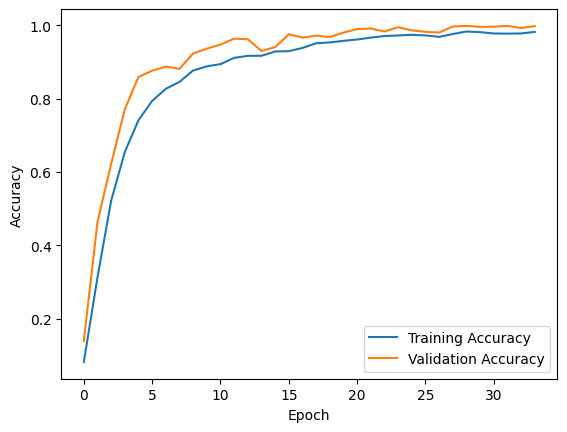

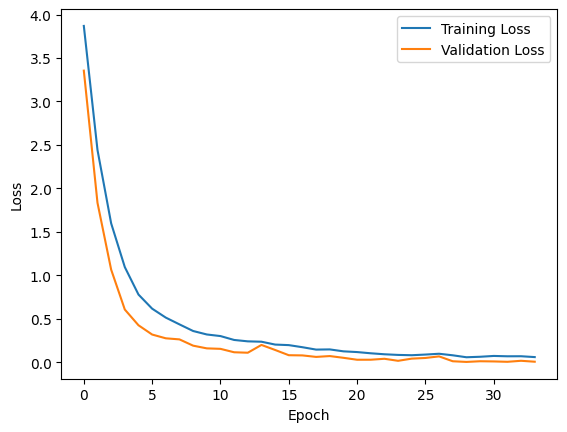

In [23]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2. Evaluate on Test set

In [24]:
model = tf.keras.models.load_model('Models/checkpoints/ViSL_model_v3.keras')

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 442ms/step - accuracy: 0.9990 - loss: 0.0028
Test Accuracy: 0.9990
Test Loss: 0.0028


In [36]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 567ms/step


2025-10-31 22:40:18.834756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
id2label = {v: k for k, v in label_map.items()}
for index in range (len(y_pred)):
    print(str(id2label[y_true[index]])+'-----------------'+str(id2label[y_pred[index]]))

mùa thu-----------------mùa thu
con tôm-----------------con tôm
giao thông-----------------giao thông
con gấu-----------------con gấu
giận dữ-----------------giận dữ
chạy-----------------chạy
mùa đông-----------------mùa đông
con gấu-----------------con gấu
quả dừa-----------------quả dừa
con lợn (con heo)-----------------con lợn (con heo)
xe cứu thương-----------------xe cứu thương
ngạc nhiên-----------------ngạc nhiên
buổi sáng-----------------buổi sáng
phi công-----------------phi công
hoa cúc-----------------hoa cúc
ban đêm-----------------ban đêm
bay nhanh (máy bay)-----------------bay nhanh (máy bay)
bút-----------------bút
chị-----------------chị
đèn xanh-----------------đèn xanh
ban ngày-----------------ban ngày
buổi sáng-----------------buổi sáng
em gái-----------------em gái
quạt trần-----------------quạt trần
phi công-----------------phi công
hoa giấy-----------------hoa giấy
máy tính (laptop)-----------------máy tính (laptop)
con cá-----------------con cá
quả dưa hấu-------